# Реккурентные нейронные сети для извлечения именованных сущностей

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, concatenate
from keras.layers import *
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import *

Using TensorFlow backend.


## Данные

In [2]:
df = pd.read_csv('../data/ner.csv', encoding = "ISO-8859-1", error_bad_lines=False)

df.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [3]:
data = []
sent = []

for index, item in df.iterrows():    
    if (item.word in ['.', '?', '!', '...']):
        sent.append([str(item.lemma),str(item.tag)])
        data.append(sent)
        sent = []
    else:
        sent.append([str(item.word),str(item.tag)])

In [4]:
data[0]

[['Thousands', 'O'],
 ['of', 'O'],
 ['demonstrators', 'O'],
 ['have', 'O'],
 ['marched', 'O'],
 ['through', 'O'],
 ['London', 'B-geo'],
 ['to', 'O'],
 ['protest', 'O'],
 ['the', 'O'],
 ['war', 'O'],
 ['in', 'O'],
 ['Iraq', 'B-geo'],
 ['and', 'O'],
 ['demand', 'O'],
 ['the', 'O'],
 ['withdrawal', 'O'],
 ['of', 'O'],
 ['British', 'B-gpe'],
 ['troops', 'O'],
 ['from', 'O'],
 ['that', 'O'],
 ['country', 'O'],
 ['.', 'O']]

Предобработка: формируем признаки и целевую переменную, находим уникальное количество слов и максимальную длину предложения:

In [5]:
lengths = [len(x) for x in data]
X = [' '.join([word[0] for word in sent]) for sent in data]
y = [[word[1] for word in sent] for sent in data]

all_text = [word for sent in X for word in sent]
words = list(set(all_text))
maxlen = max([len(x.split()) for x in X])

Последовательности для обучения:

In [6]:
tokenizer = Tokenizer(num_words=len(words))
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(sequences, maxlen=maxlen)

Преобразования целевого признака: посчитаем сколько раз встречается каждый тег

In [7]:
from nltk import FreqDist
fd = FreqDist()
for i in y:
    fd.update(i)

n_tags = len(list(fd.keys()))

Подготавливаем последовательности:

In [8]:
encoder = LabelEncoder()
encoder.fit(list(fd.keys()))
y_enc = [encoder.transform(sent) for sent in y] 
y_padded = pad_sequences(y_enc, maxlen=maxlen, value = list(encoder.classes_).index('O'))
y_cat  = [to_categorical(sent, num_classes=n_tags) for sent in y_padded]

In [9]:
n_tags  = len(fd.keys())

In [10]:
print(y[0])
print(y_enc[0])
print(y_padded[0])
print(y_cat[0])
print(len(y_enc[0]))
print(len(y_cat[0][0]))
print(len(list(fd.keys())))

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
[16 16 16 16 16 16  2 16 16 16 16 16  2 16 16 16 16 16  3 16 16 16 16 16]
[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  2 16 16 16 16 16  2
 16 16 16 16 16  3 16 16 16 16 16]
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
24
18
18


Размерности данных:

In [11]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X_padded, np.asarray(y_cat), test_size=0.332, random_state=42)

print ('Train data shapes:')
print(len(X_train), len(X_train[0]), len(Y_train), len(Y_train[0]))
print ('Test data shapes:')
print(len(X_test), len(X_test[0]), len(Y_test), len(Y_test[0]))

Train data shapes:
32053 86 32053 86
Test data shapes:
15932 86 15932 86


Параметры обучения:

In [12]:
max_features = len(words)
embedding_size = 100
hidden_size = 32
out_size = n_tags
nb_epoch = 20
batch_size = 32

Нейронная сеть:

In [13]:
# model = Sequential()
# model.add(Embedding(max_features, embedding_size, input_length=maxlen))
# model.add(Bidirectional(LSTM(hidden_size, return_sequences = True)))
# model.add(TimeDistributed(Dense(out_size, activation = 'softmax')))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# for i in range(nb_epoch):
#     model.fit(X_train, Y_train, batch_size=batch_size, epochs=1)
#     model.save('../models/bilstm_'+str(i)+'.h5')
model = load_model('../models/bilstm_'+str(19)+'.h5')

In [14]:
score = model.evaluate(X_test, Y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

15932/15932 [==============================] - 19s 1ms/step

In [15]:
pred = model.predict(X_test)

In [16]:
pred_argmax = [[np.argmax(word) for word in sent] for sent in pred]
y_pred = encoder.inverse_transform(pred_argmax)
Y_test_argmax = [[np.argmax(word) for word in sent] for sent in Y_test]
y_true = encoder.inverse_transform(Y_test_argmax)

In [17]:
from sklearn_crfsuite import metrics

labels=list(fd.keys())

sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(y_true, y_pred, labels = sorted_labels , digits=3))

             precision    recall  f1-score   support

          O      0.963     0.999     0.981   1316916
      B-art      0.000     0.000     0.000       155
      I-art      0.000     0.000     0.000       116
      B-eve      0.000     0.000     0.000       114
      I-eve      0.000     0.000     0.000       108
      B-geo      0.470     0.053     0.095     12539
      I-geo      0.830     0.033     0.064      2507
      B-gpe      0.640     0.003     0.006      5448
      I-gpe      0.000     0.000     0.000        81
      B-nat      0.000     0.000     0.000        60
      I-nat      0.000     0.000     0.000        24
      B-org      0.000     0.000     0.000      6663
      I-org      0.417     0.011     0.022      5269
      B-per      0.410     0.012     0.024      5604
      I-per      0.479     0.066     0.116      5717
      B-tim      0.710     0.081     0.146      6723
      I-tim      0.710     0.023     0.045      2107
        nan      0.000     0.000     0.000   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
y_true_flat = metrics.flatten(y_true)
y_pred_flat = metrics.flatten(y_pred)

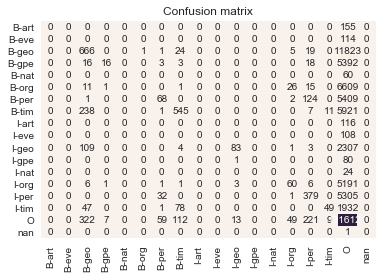

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
%matplotlib inline


sns.heatmap(data=confusion_matrix(y_true_flat, y_pred_flat), annot=True, fmt="d", cbar=False, xticklabels=list(encoder.classes_), yticklabels=list(encoder.classes_))
plt.title("Confusion matrix")
plt.show()

## Задание

Добавьте POS-тэги к обучению: 
* посчитайте, сколько всего тегов использовано для разметки текстов;
* пронумеруйте теги и замените каждый тег на его порядковый номер;
* разбейте теги на обучающее и тестовое множество;
* создайте две входные модели с эмбеддингами: модель слов и модель тегов;
* используйте код ниже для конкатенации моделей и обучения общей модели. 

In [25]:
concat = Concatenate()([word_model.output,pos_model.output])
concat = Bidirectional(LSTM(hidden_size, return_sequences = True))(concat)
concat = TimeDistributed(Dense(out_size, activation = 'softmax'))(concat)

model = Model([word_model.input, pos_model.input], concat)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit([X_train, pos_train], Y_train, batch_size=batch_size, epochs=1)

Epoch 1/1
32053/32053 [==============================] - 191s 6ms/step - loss: 0.1644 - acc: 0.9684

## Модель biLSTM-CRF

Добавим слой с CRF в нейронную сеть. Для этого используем дополнительные слои из keras_contrib.

In [47]:
from keras_contrib.layers import CRF
from keras_contrib.utils import save_load_utils
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Bidirectional(LSTM(hidden_size, return_sequences = True)))
model.add(TimeDistributed(Dense(hidden_size, activation = 'softmax')))

crf = (CRF(n_tags))
model.add(crf)

model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

# for i in range(nb_epoch):
#     model.fit(X_train, Y_train, batch_size=batch_size, epochs=1)
#     save_load_utils.save_all_weights(model,'../models/bilstm_crf_'+str(i)+'.h5')



save_load_utils.load_all_weights(model, '../models/bilstm_crf_'+str(1)+'.h5')

Оценка качества модели:

In [48]:
score = model.evaluate(X_test, Y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

15932/15932 [==============================] - 105s 7ms/step

In [49]:
pred = model.predict(X_test)

In [50]:
pred_argmax = [[np.argmax(word) for word in sent] for sent in pred]
y_pred = encoder.inverse_transform(pred_argmax)
Y_test_argmax = [[np.argmax(word) for word in sent] for sent in Y_test]
y_true = encoder.inverse_transform(Y_test_argmax)

In [51]:
print(metrics.flat_classification_report(y_true, y_pred, labels=list(fd.keys()), digits=3))

             precision    recall  f1-score   support

        NNS      0.000     0.000     0.000         0
         IN      0.000     0.000     0.000       108
        VBP      0.000     0.000     0.000         0
        VBN      0.000     0.000     0.000         0
        NNP      0.961     1.000     0.980   1316916
         TO      0.000     0.000     0.000         0
         VB      0.000     0.000     0.000         0
         DT      0.000     0.000     0.000      6723
         NN      0.000     0.000     0.000      2107
         CC      0.000     0.000     0.000      6663
         JJ      0.000     0.000     0.000      2507
          .      0.000     0.000     0.000     12539
        VBD      0.000     0.000     0.000         0
         WP      0.000     0.000     0.000         0
         ``      0.000     0.000     0.000         0
         CD      0.000     0.000     0.000      5604
        PRP      0.000     0.000     0.000         0
        VBZ      0.000     0.000     0.000   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


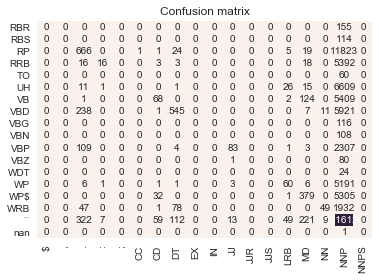

In [52]:
sns.heatmap(data=confusion_matrix(y_true_flat, y_pred_flat), annot=True, fmt="d", cbar=False, xticklabels=list(encoder.classes_), yticklabels=list(encoder.classes_))
plt.title("Confusion matrix")
plt.show()